In [1]:
import socket
import struct
import zlib
import tempfile
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras import layers, initializers, backend as K
from sklearn.metrics import confusion_matrix, accuracy_score
import base64
import hashlib

In [2]:
# Custom Capsule Network Components
@register_keras_serializable(package="Custom")
class Length(layers.Layer):
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1) + K.epsilon())
    
    def compute_output_shape(self, input_shape):
        return input_shape[:-1]
    
    def get_config(self):
        return super(Length, self).get_config()

@tf.keras.saving.register_keras_serializable(package="Custom")
class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, **kwargs):
        super().__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]
        
        self.W = self.add_weight(
            shape=[1, self.input_num_capsule, self.num_capsule, self.dim_capsule, self.input_dim_capsule],
            initializer=initializers.glorot_uniform(),
            name='W'
        )
        self.built = True

    def call(self, inputs):
        inputs_expand = K.expand_dims(K.expand_dims(inputs, 2), 2)
        W_tiled = K.tile(self.W, [K.shape(inputs)[0], 1, 1, 1, 1])
        inputs_hat = tf.squeeze(tf.matmul(W_tiled, inputs_expand, transpose_b=True), axis=-1)
        b = tf.zeros(shape=[K.shape(inputs)[0], self.input_num_capsule, self.num_capsule])

        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=2)
            c_expand = K.expand_dims(c, -1)
            outputs = self.squash(tf.reduce_sum(inputs_hat * c_expand, axis=1))
            if i < self.routings - 1:
                b += tf.reduce_sum(inputs_hat * K.expand_dims(c, -1), axis=-1)
        
        return outputs
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_capsule": self.num_capsule,
            "dim_capsule": self.dim_capsule,
            "routings": self.routings
        })
        return config
    def squash(self, vectors, axis=-1):
        s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
        scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
        return scale * vectors

@tf.keras.saving.register_keras_serializable(package="Custom", name="margin_loss")
def margin_loss(y_true, y_pred):
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=2)
    L = y_true * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))
    return tf.reduce_mean(tf.reduce_sum(L, axis=1))

class MobileNetCapsNet:
    def __init__(self, input_shape=(224, 224, 3)):
        self.input_shape = input_shape
        self.model = self._build_model()
    
    def _build_model(self):
        base_model = tf.keras.applications.MobileNetV2(
            input_shape=self.input_shape,
            include_top=False,
            weights='imagenet'
        )
        base_model.trainable = False
        
        x = base_model.output
        x = layers.Conv2D(256, 3, activation='relu')(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Reshape((-1, 256))(x)
        
        x = CapsuleLayer(num_capsule=8, dim_capsule=16, routings=3)(x)
        x = CapsuleLayer(num_capsule=2, dim_capsule=32, routings=3)(x)
        outputs = Length()(x)
        
        return tf.keras.Model(inputs=base_model.input, outputs=outputs)
    
    def compile_model(self, learning_rate=0.001):
        """Compile the model with appropriate loss and optimizer"""
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        
        self.model.compile(
            optimizer=optimizer,
            loss=self.margin_loss,
            metrics=['accuracy']
        )
        
    @staticmethod
    def margin_loss(y_true, y_pred):
        """Margin loss for capsule network"""
        # Convert y_true to one-hot if it isn't already
        if len(K.int_shape(y_true)) == 1:
            y_true = tf.one_hot(tf.cast(y_true, 'int32'), 2)
            
        L = y_true * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
            0.5 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))
        return tf.reduce_mean(tf.reduce_sum(L, axis=1))

In [3]:
from tensorflow.keras.models import load_model
Teacher_model_mobilenet_capsulenet = load_model(r"C:\Users\GURU\Downloads\drowsiness_model_teacher_very_less_complex.keras",custom_objects={"CapsuleLayer": CapsuleLayer,"Length":Length,"margin_loss":margin_loss})
Vgg16_model = load_model(r"D:\Major Project\Rasp\model\drowsiness_vgg_16_model_teacher_5_epoch.keras")
Student_model_pre = load_model(r"C:\Users\GURU\Downloads\drowsiness_model_student.keras",custom_objects={"CapsuleLayer": CapsuleLayer,"Length":Length,"margin_loss":margin_loss})
Student_model_post = load_model(r"C:\Users\GURU\Downloads\drowsiness_model_student_Distilled_5_epoch.keras",custom_objects={"CapsuleLayer": CapsuleLayer,"Length":Length,"margin_loss":margin_loss})

D:\Major Project\venv\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [18]:
Student_model_post.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 16)      │             432 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 16)      │              64 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 16)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 16)      │             144 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 16)      │              64 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 16)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 8)       │             128 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 8)       │              32 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 48)      │             384 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 48)      │             192 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 48)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 48)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 48)        │             432 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 574,438 (2.19 MB)

 Trainable params: 82,114 (320.76 KB)

 Non-trainable params: 410,208 (1.56 MB)

 Optimizer params: 82,116 (320.77 KB)

In [27]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Load model
model = VGG16(include_top=False, input_shape=(224, 224, 3))

# Call the model once to build it
dummy_input = tf.random.normal([1, 224, 224, 3])
_ = model(dummy_input)

# Function to get GFLOPs
def get_gflops(model):
    concrete_func = tf.function(model).get_concrete_function(
        tf.TensorSpec([1, 224, 224, 3], tf.float32)
    )
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph = frozen_func.graph

    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

    flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, options=opts)

    if flops is not None:
        gflops = flops.total_float_ops / 1e9
        return round(gflops, 2)
    else:
        return None

# Print GFLOPs
gflops = get_gflops(model)
print(f"GFLOPs: {gflops} G")


GFLOPs: 30.71 G


In [28]:
import time
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 0.001
TEST_SIZE = 0.2
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    r"D:\Major Project\Rasp\old\test",
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)
y_true = test_gen.classes.astype(int)
x=time.time()
y_raw = Vgg16_model.predict(test_gen)
y=time.time()
if y_raw.shape[-1] == 1:
    # Binary classification: sigmoid output
    y_prob = y_raw.ravel()
    y_pred = (y_prob > 0.5).astype(int)
elif y_raw.shape[-1] == 2 and len(np.unique(y_true)) == 2:
    # Binary classification: softmax output over 2 classes
    y_prob = y_raw[:, 1]  # Probability of class 1 (Drowsy)
    y_pred = np.argmax(y_raw, axis=1)
else:
    # Multi-class case
    y_prob = y_raw
    y_pred = np.argmax(y_prob, axis=1)
# if y_raw.shape[-1] == 1:
#     # Binary classification: sigmoid
#     y_prob = y_raw.ravel()
#     y_pred = (y_prob > 0.5).astype(int)
# elif y_raw.shape[-1] == 2 and len(np.unique(y_true)) == 2:
#     # Binary classification: softmax output over 2 classes
#     y_prob = y_raw[:, 1]  # Use probability of class 1 (Drowsy)
#     y_pred = np.argmax(y_raw, axis=1)
# else:
#     # Multi-class case
#     y_prob = y_raw
#     y_pred = np.argmax(y_prob, axis=1)

Found 7045 images belonging to 2 classes.


D:\Major Project\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


221/221 ━━━━━━━━━━━━━━━━━━━━ 614s 3s/step


In [29]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
)
inference_time = y-x
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='binary' if y_prob.ndim == 1 or y_prob.shape[1] == 1 else 'macro')
rec = recall_score(y_true, y_pred, average='binary' if y_prob.ndim == 1 or y_prob.shape[1] == 1 else 'macro')
f1 = f1_score(y_true, y_pred, average='binary' if y_prob.ndim == 1 or y_prob.shape[1] == 1 else 'macro')
print('accuracy',acc)
print('precision',prec)
print('recall',rec)
print('f1',f1)
print('inference_time',inference_time)

accuracy 0.6422995031937544
precision 0.5812057498390903
recall 0.8266707354287458
f1 0.6825396825396826
inference_time 614.1025941371918


In [4]:
models = {
    "Teacher (MobileNet+CapsNet)": Teacher_model_mobilenet_capsulenet,
    "VGG16": Vgg16_model,
    "Student Pre-KD": Student_model_pre,
    "Student Post-KD": Student_model_post
}


In [5]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
)

def evaluate_all_models(models, dataset_dir):
    results = {}

    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    test_gen = test_datagen.flow_from_directory(
        dataset_dir,
        target_size=INPUT_SHAPE[:2],
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False
    )

    y_true = test_gen.classes.astype(int)

    for name, model in models.items():
        print(f"Evaluating: {name}")

        y_raw = model.predict(test_gen)
        if y_raw.shape[-1] == 1:
            # Binary classification: sigmoid output
            y_prob = y_raw.ravel()
            y_pred = (y_prob > 0.5).astype(int)
        elif y_raw.shape[-1] == 2 and len(np.unique(y_true)) == 2:
            # Binary classification: softmax output over 2 classes
            y_prob = y_raw[:, 1]  # Probability of class 1 (Drowsy)
            y_pred = np.argmax(y_raw, axis=1)
        else:
            # Multi-class case
            y_prob = y_raw
            y_pred = np.argmax(y_prob, axis=1)
        # if y_raw.shape[-1] == 1:
        #     # Binary classification: sigmoid
        #     y_prob = y_raw.ravel()
        #     y_pred = (y_prob > 0.5).astype(int)
        # elif y_raw.shape[-1] == 2 and len(np.unique(y_true)) == 2:
        #     # Binary classification: softmax output over 2 classes
        #     y_prob = y_raw[:, 1]  # Use probability of class 1 (Drowsy)
        #     y_pred = np.argmax(y_raw, axis=1)
        # else:
        #     # Multi-class case
        #     y_prob = y_raw
        #     y_pred = np.argmax(y_prob, axis=1)



        # Classification metrics
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='binary' if y_prob.ndim == 1 or y_prob.shape[1] == 1 else 'macro')
        rec = recall_score(y_true, y_pred, average='binary' if y_prob.ndim == 1 or y_prob.shape[1] == 1 else 'macro')
        f1 = f1_score(y_true, y_pred, average='binary' if y_prob.ndim == 1 or y_prob.shape[1] == 1 else 'macro')

        # ROC & PR curve (only for binary)
        if y_prob.ndim == 1 or y_prob.shape[1] == 1:
            fpr, tpr, _ = roc_curve(y_true, y_prob)
            auc_score = auc(fpr, tpr)
            pr, rc, _ = precision_recall_curve(y_true, y_prob)
            avg_pr = average_precision_score(y_true, y_prob)

        else:
            fpr, tpr, auc_score = None, None, None
            pr, rc, avg_pr = None, None, None

        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

        results[name] = {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'roc': (fpr, tpr, auc_score),
            'pr': (rc, pr, avg_pr),
            'confusion_matrix': cm,
            'y_true': y_true,
            'y_pred': y_pred,
            'y_prob': y_prob
        }

    return results


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_all_comparisons(results_dict):
    model_names = list(results_dict.keys())

    # Accuracy / Top-1
    acc = [results_dict[name]['accuracy'] for name in model_names]
    
    plt.figure(figsize=(8, 5))
    x = np.arange(len(model_names))
    plt.bar(x, acc, label='Accuracy', color='skyblue')
    plt.xticks(x, model_names)
    plt.ylabel('Score')
    plt.title('Model Accuracy Comparison')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Precision / Recall / F1
    precs = [results_dict[name]['precision'] for name in model_names]
    recs = [results_dict[name]['recall'] for name in model_names]
    f1s = [results_dict[name]['f1'] for name in model_names]

    plt.figure(figsize=(9,5))
    x = np.arange(len(model_names))
    width = 0.25
    plt.bar(x - width, precs, width, label='Precision')
    plt.bar(x, recs, width, label='Recall')
    plt.bar(x + width, f1s, width, label='F1 Score')
    plt.xticks(x, model_names)
    plt.title("Precision / Recall / F1")
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

    # ROC Curve
    plt.figure(figsize=(8,6))
    for name in model_names:
        fpr, tpr, auc_score = results_dict[name]['roc']
        
        # Only plot if fpr and tpr are valid (not None)
        if fpr is not None and tpr is not None:
            if auc_score is not None:
                plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")
            else:
                plt.plot(fpr, tpr, label=f"{name} (AUC not available)")
        else:
            plt.plot([0, 1], [0, 1], 'k--', label=f"{name} (No ROC data)")
            
    plt.plot([0,1], [0,1], 'k--')
    plt.title("ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()



    # PR Curve
    plt.figure(figsize=(8,6))
    for name in model_names:
        rc, pr, avg_pr = results_dict[name]['pr']
        plt.plot(rc, pr, label=f"{name} (AP = {avg_pr:.2f})")
    plt.title("Precision-Recall Curves")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

    # Confusion Matrices
    n = len(model_names)
    cols = 2
    rows = (n + 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(10, 4 * rows))

    for i, name in enumerate(model_names):
        ax = axs[i // cols, i % cols] if rows > 1 else axs[i]
        cm = results_dict[name]['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Not Drowsy', 'Drowsy'],
                    yticklabels=['Not Drowsy', 'Drowsy'],
                    ax=ax)
        ax.set_title(f"{name} - Confusion Matrix")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

    plt.tight_layout()
    plt.show()


In [7]:
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 0.001
TEST_SIZE = 0.2

In [8]:
results = evaluate_all_models(models, dataset_dir=r"D:\Major Project\Rasp\old\test")

Found 7045 images belonging to 2 classes.
Evaluating: Teacher (MobileNet+CapsNet)


D:\Major Project\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


221/221 ━━━━━━━━━━━━━━━━━━━━ 90s 404ms/step
Evaluating: VGG16
221/221 ━━━━━━━━━━━━━━━━━━━━ 645s 3s/step
Evaluating: Student Pre-KD
221/221 ━━━━━━━━━━━━━━━━━━━━ 47s 208ms/step
Evaluating: Student Post-KD
221/221 ━━━━━━━━━━━━━━━━━━━━ 47s 207ms/step


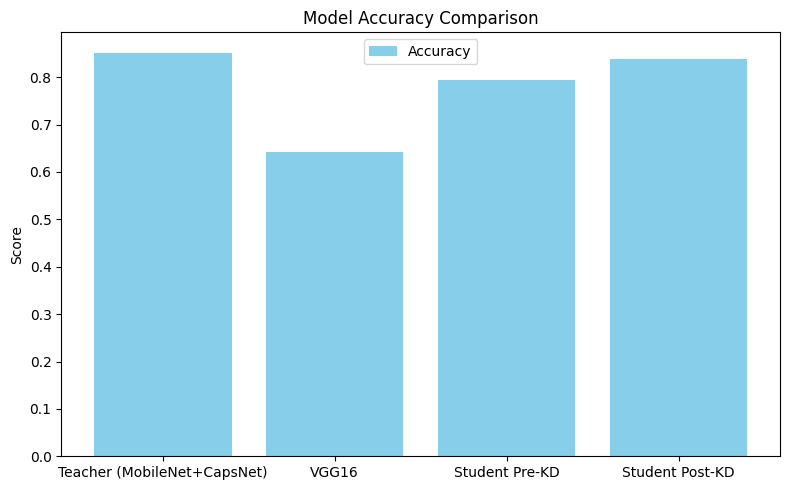

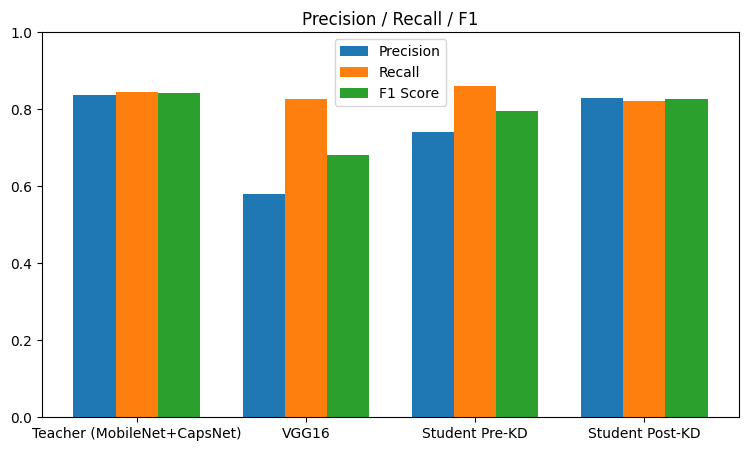

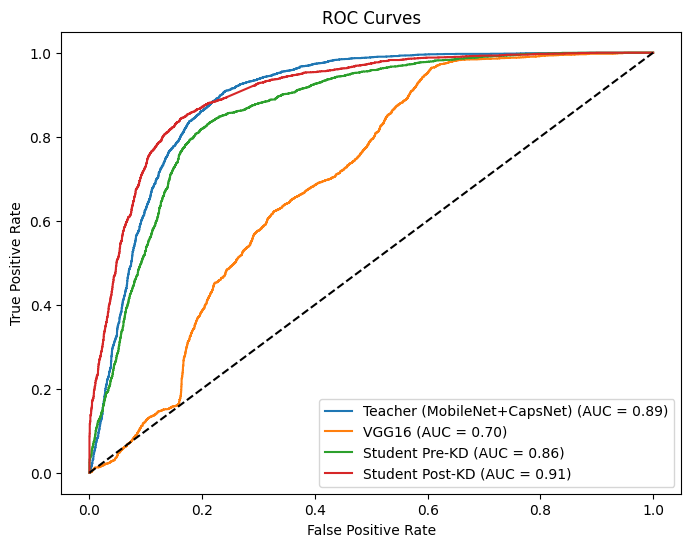

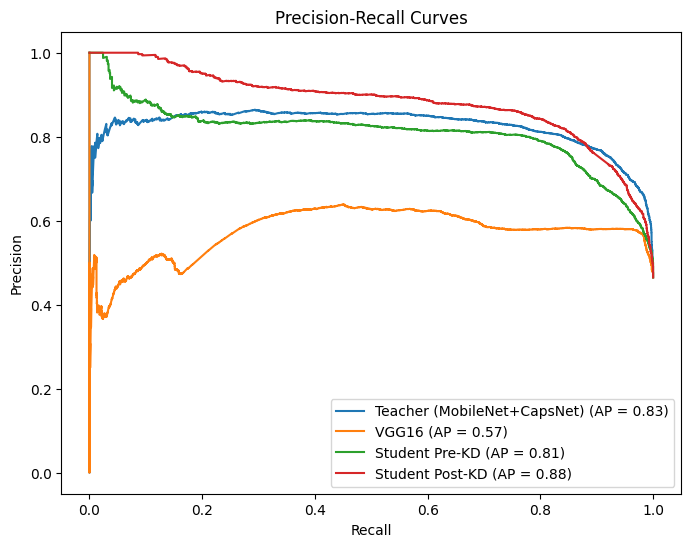

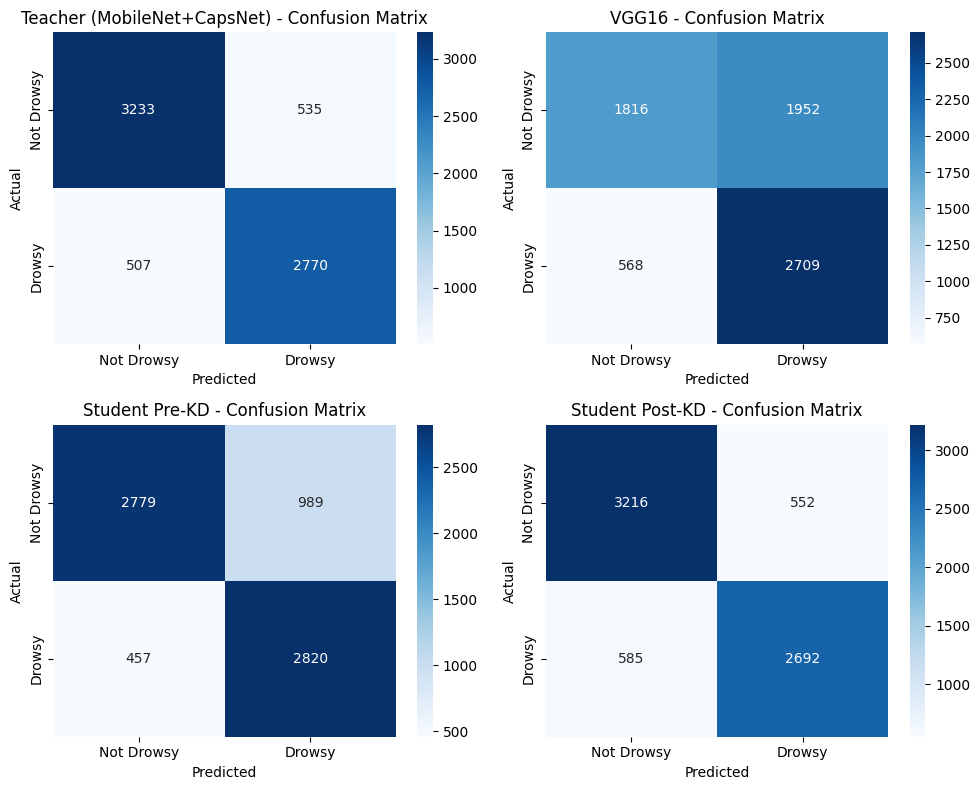

In [9]:
plot_all_comparisons(results)